In [1]:
import numpy as np
from filters.iekf import IEKF
from tools.objects import Gaussian
from tools.plot import plot2dcov
import mrob
from matplotlib import pyplot as plt

In [2]:
def ciplot(t, mu, minus_sigma, plus_sigma, x_real, color=None):
    """
    Plots a shaded region on a graph between specified lower and upper confidence intervals (L and U).

    :param t: The time series corresponding to the state.
    :param mu: The predicted state of the variable.
    :param minus_sigma: THe lower bound of the confidence interval.
    :param plus_sigma: The upper bound of the confidence interval.
    :param x_real: The real value of the state variable.
    :param color: Color of the fill inside the lower and upper bound curves (optional).
    :return handle: The handle to the plot of the state variable.
    """

    assert minus_sigma.shape[0] == plus_sigma.shape[0]
    assert t.shape[0] == mu.shape[0]

    plt.fill_between(t, minus_sigma, plus_sigma, color=color, alpha=0.5)
    x_pred, = plt.plot(t, mu)
    x_real, = plt.plot(t, x_real)

    return x_pred, x_real

In [3]:
a = np.eye(3) @ np.ones(3).reshape(-1, 1)
b = np.eye(3) @ np.ones(3).reshape(-1, 1) * 2
c = np.eye(3) @ np.ones(3).reshape(-1, 1) * 3

In [4]:
a

array([[1.],
       [1.],
       [1.]])

In [5]:
np.hstack((a,b, c))

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [6]:
mean_prior = np.array([1., 0, 0.])
Sigma_prior = 1e-12 * np.eye(3, 3)
M = 1e-8 * np.eye(3, 3)
Q = 1e-12 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
b = np.array([0.01, 0, 0])

In [7]:
iekf = IEKF(initial_state, M, Q, g, b)

In [8]:
iekf.mu_bar

array([1., 0., 0.])

In [9]:
mrob.geometry.SO3(iekf.mu_bar).Ln()

array([ 1.,  0., -0.])

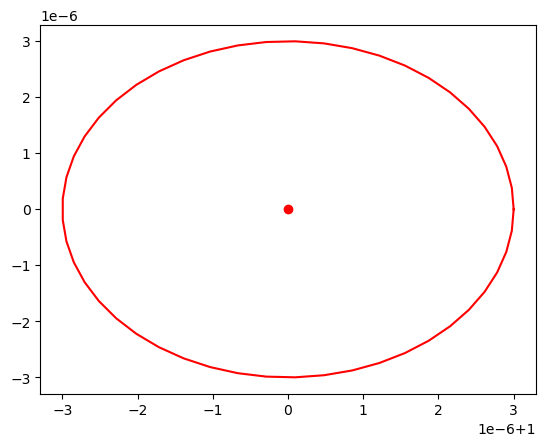

In [10]:
plot2dcov(iekf.mu_bar[:-1],
            iekf.Sigma_bar[:-1, :-1],
            'red', 3,
            legend='{} - IEKF')

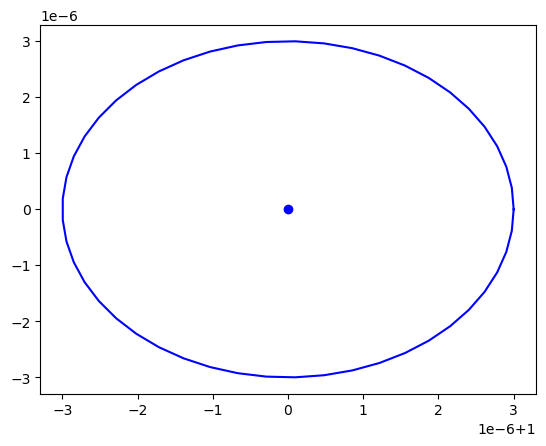

In [11]:
plot2dcov(iekf.mu[:-1],
            iekf.Sigma[:-1, :-1],
            'blue', 3,
            legend='{} - IEKF')

In [12]:
iekf.mu

array([1., 0., 0.])

In [13]:
u = np.array([0.1, 0, 0])
dt = 1

In [14]:
iekf.predict(u, dt)

In [15]:
g = np.array([0, 0, -9.81])
iekf.update(g)

(array([[ 0.        ,  0.04714423,  0.09037982],
        [-0.04714423,  0.        ,  0.        ],
        [-0.09037982,  0.        ,  0.        ]]),
 array([0.        , 8.69781003, 5.27301855]))

In [16]:
mrob.geometry.SO3([1.1, 0, 0]).mul(mrob.geometry.SO3(u*dt))

        1         0         0
        0  0.362358 -0.932039
        0  0.932039  0.362358

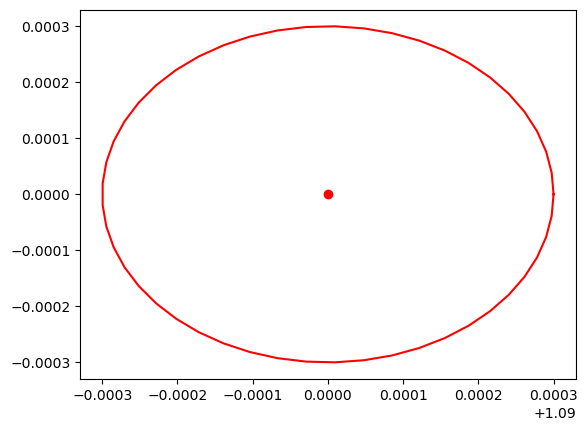

In [17]:
plot2dcov(iekf.mu_bar[:-1],
            iekf.Sigma_bar[:-1, :-1],
            'red', 3,
            legend='{} - IEKF')

In [18]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e0 * np.eye(3, 3)
Q = 1e-2 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0.1, 0])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = np.array([0.1, 0, 0])
dt = 1
N = 200
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
gt = np.empty((N, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))

In [19]:
for i in range(N):
    iekf.predict(u, dt)
    Ks[i], IVs[i] = iekf.update(mrob.geometry.SO3(np.random.normal(0, 0.1, 3)).R()@mrob.geometry.SO3(iekf.mu_bar).R().T@g)
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma
    gt[i] = mrob.geometry.SO3(iekf.mu_bar).Ln() #np.mod(u*(i+1)+np.pi, 2*np.pi) - np.pi

In [20]:
mrob.geometry.SO3([0.1, 0, 0]).R()

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99500417, -0.09983342],
       [ 0.        ,  0.09983342,  0.99500417]])

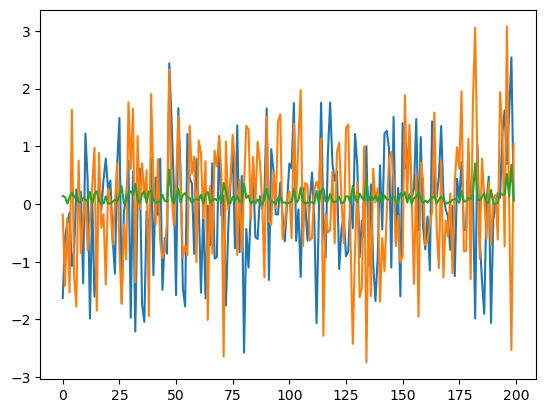

In [21]:
plt.plot(IVs)

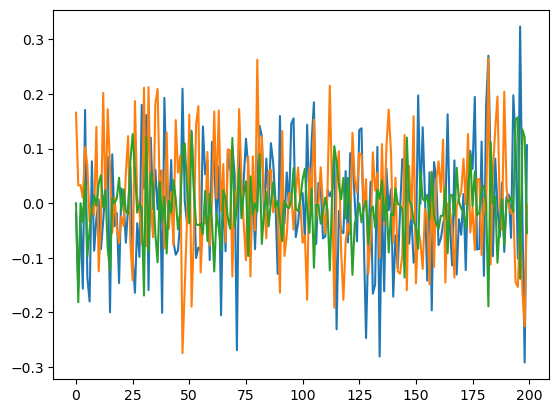

In [22]:
plt.plot(np.array([Ks[i] @ IVs[i] for i in range(len(Ks))]))

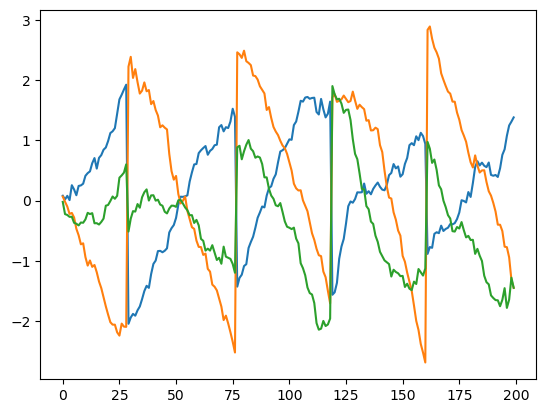

In [23]:
plt.plot(ups)

In [24]:
ups

array([[ 8.00578583e-02,  6.67060177e-02, -2.22654795e-02],
       [ 1.88297359e-02, -1.97558809e-02, -2.24917863e-01],
       [ 7.87285739e-02, -9.95715575e-02, -2.39407454e-01],
       [ 7.62777633e-03, -2.21866583e-01, -2.70536316e-01],
       [ 2.54936412e-01, -2.05495914e-01, -2.68626445e-01],
       [ 1.83720556e-01, -2.81473772e-01, -3.69996963e-01],
       [ 8.85453862e-02, -4.69017823e-01, -3.84989922e-01],
       [ 2.42983329e-01, -5.76270383e-01, -4.12320767e-01],
       [ 2.51627143e-01, -7.26647193e-01, -3.64306112e-01],
       [ 2.80385749e-01, -7.09829451e-01, -3.68721834e-01],
       [ 4.10973188e-01, -9.38361324e-01, -3.12873750e-01],
       [ 4.55725438e-01, -1.08019212e+00, -2.03602862e-01],
       [ 4.84920815e-01, -9.95052723e-01, -2.24364292e-01],
       [ 6.20108606e-01, -1.10097556e+00, -2.08969508e-01],
       [ 7.05686160e-01, -1.07033494e+00, -3.77067674e-01],
       [ 5.30849058e-01, -1.19080748e+00, -3.75790519e-01],
       [ 7.09280701e-01, -1.34451118e+00

In [25]:
s_ups

array([[[ 3.02916543e-01,  3.43024155e-02,  1.79945418e+00],
        [ 3.43024155e-02,  3.98966516e-03,  2.03840984e-01],
        [ 1.79945418e+00,  2.03840984e-01,  1.06933016e+01]],

       [[ 2.52444842e-02,  6.15653467e-02,  4.19807287e-01],
        [ 6.15653467e-02,  1.50867780e-01,  1.02804221e+00],
        [ 4.19807287e-01,  1.02804221e+00,  7.01020993e+00]],

       [[ 8.98577543e-03,  6.79888788e-03,  2.68358000e-01],
        [ 6.79888788e-03,  5.30830544e-03,  2.05422383e-01],
        [ 2.68358000e-01,  2.05422383e-01,  8.10830351e+00]],

       ...,

       [[ 7.56702978e-02, -4.96291245e-04, -4.61674667e-01],
        [-4.96291245e-04,  1.07161180e-04,  3.03210126e-03],
        [-4.61674667e-01,  3.03210126e-03,  2.82071604e+00]],

       [[ 1.88468227e-01, -1.87654179e-01, -6.77035566e-01],
        [-1.87654179e-01,  1.87050610e-01,  6.74483091e-01],
        [-6.77035566e-01,  6.74483091e-01,  2.43356445e+00]],

       [[ 2.79441124e-04,  2.33512709e-03, -2.19433397e-02],
 

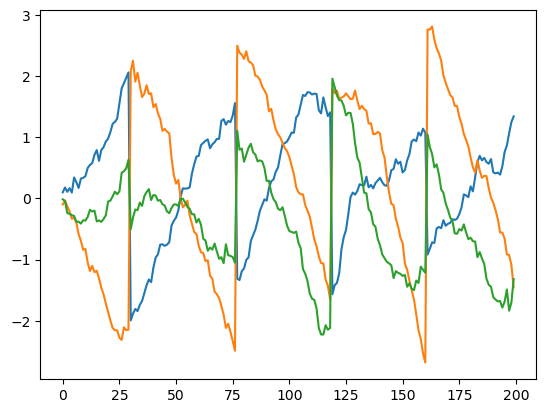

In [26]:
plt.plot(gt)

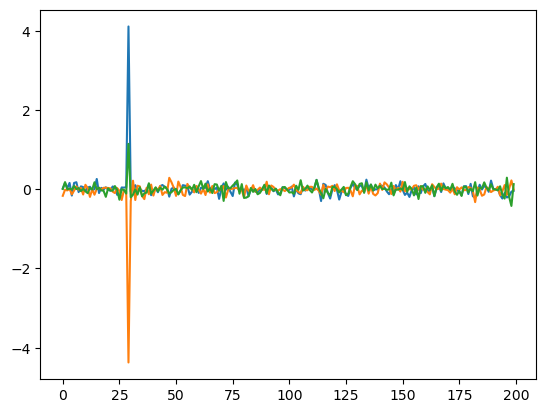

In [27]:
plt.plot(gt - ups)

In [28]:
def plot_covs(states, covs, state_i, gt):
    sigma = np.sqrt(covs[:, state_i, state_i])
    minus_sigma = states[:, state_i] - sigma
    plus_sigma = states[:, state_i] + sigma
    plt.figure(figsize=(14,8))
    t = np.array(range(len(states)))
    handles = ciplot(t, states[:, state_i], minus_sigma, plus_sigma, gt[:, state_i])


    plt.title('Direct Integration of Controls')
    plt.legend(handles, ['Estimated angle', 'Ground Truth'])
    plt.xlabel('Time')
    plt.ylabel('Translational Velocity')
    plt.show()

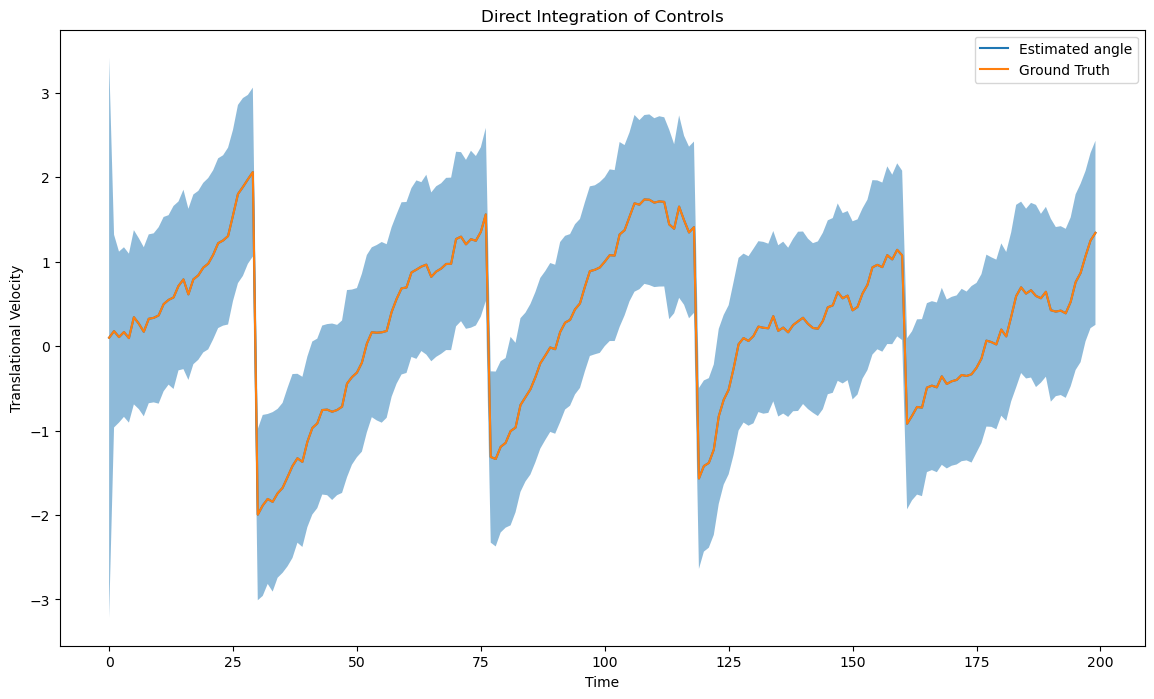

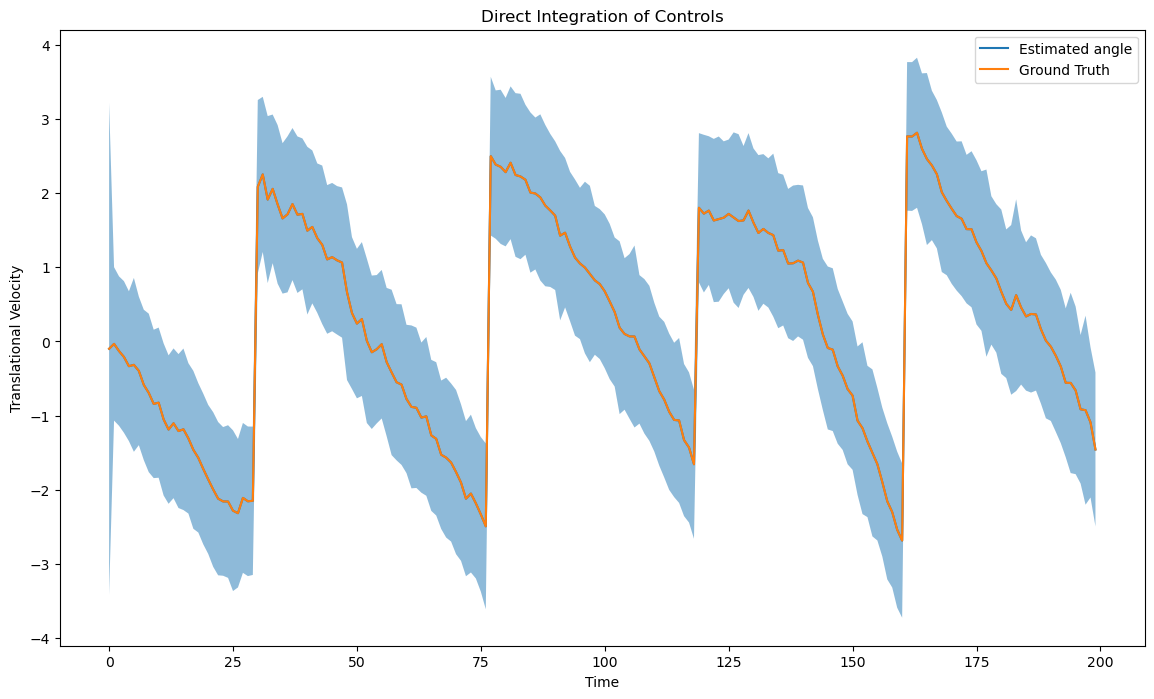

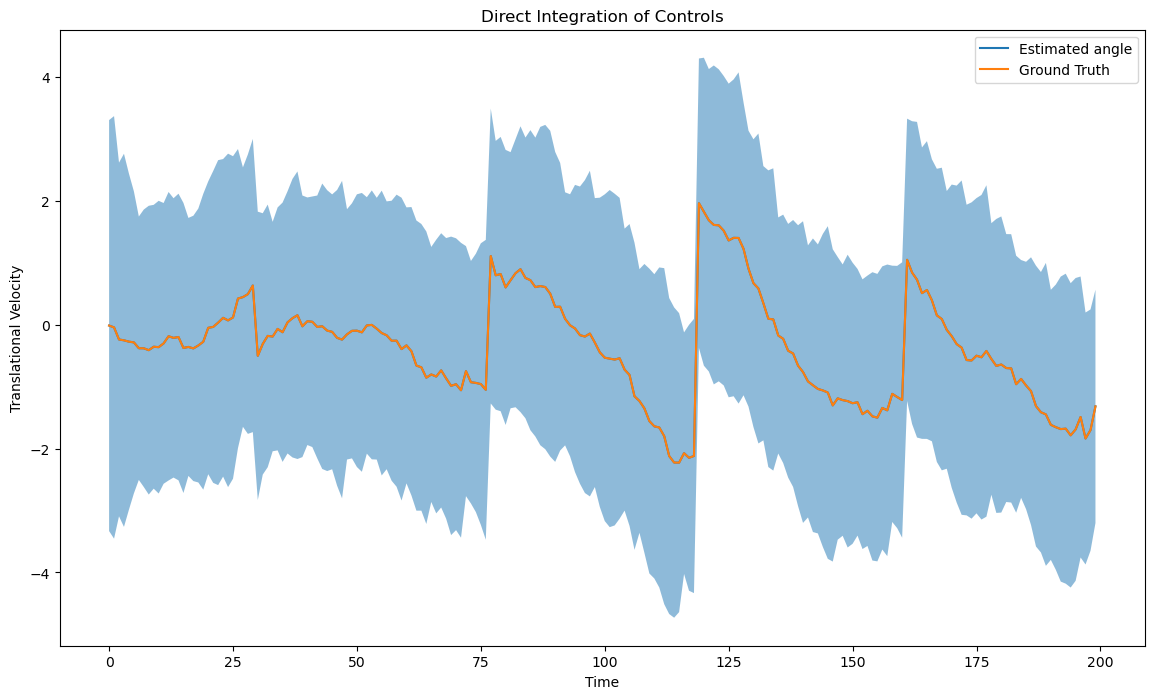

In [29]:
plot_covs(preds, s_preds, 0, gt)
plot_covs(preds, s_preds, 1, gt)
plot_covs(preds, s_preds, 2, gt)

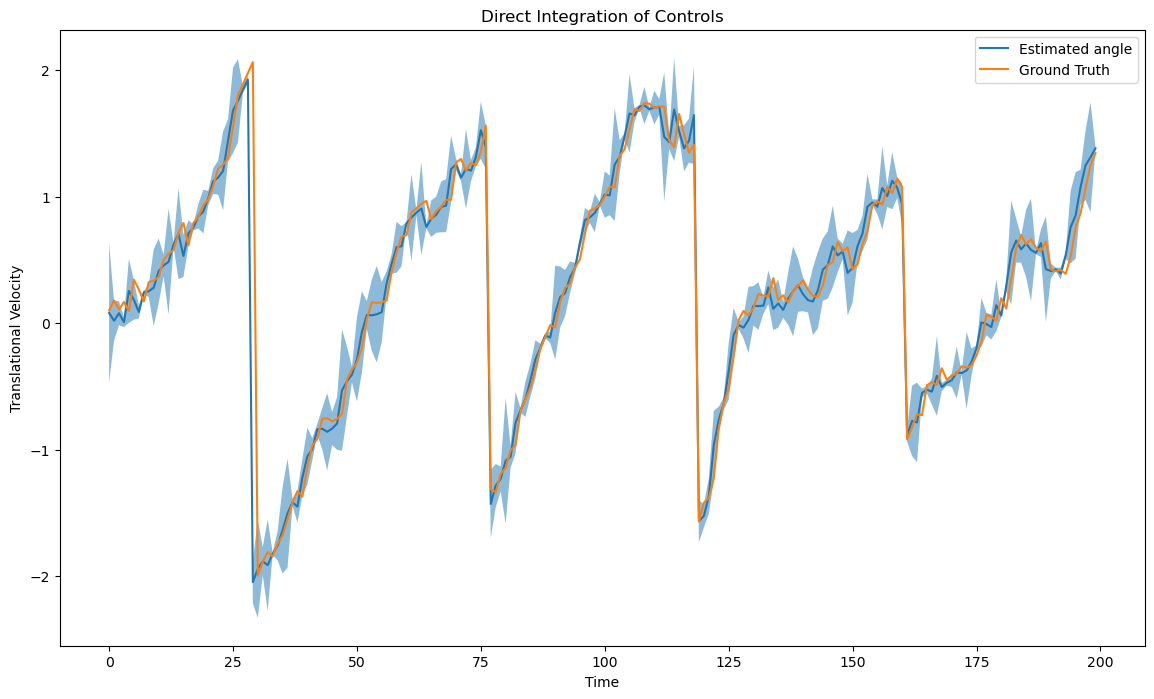

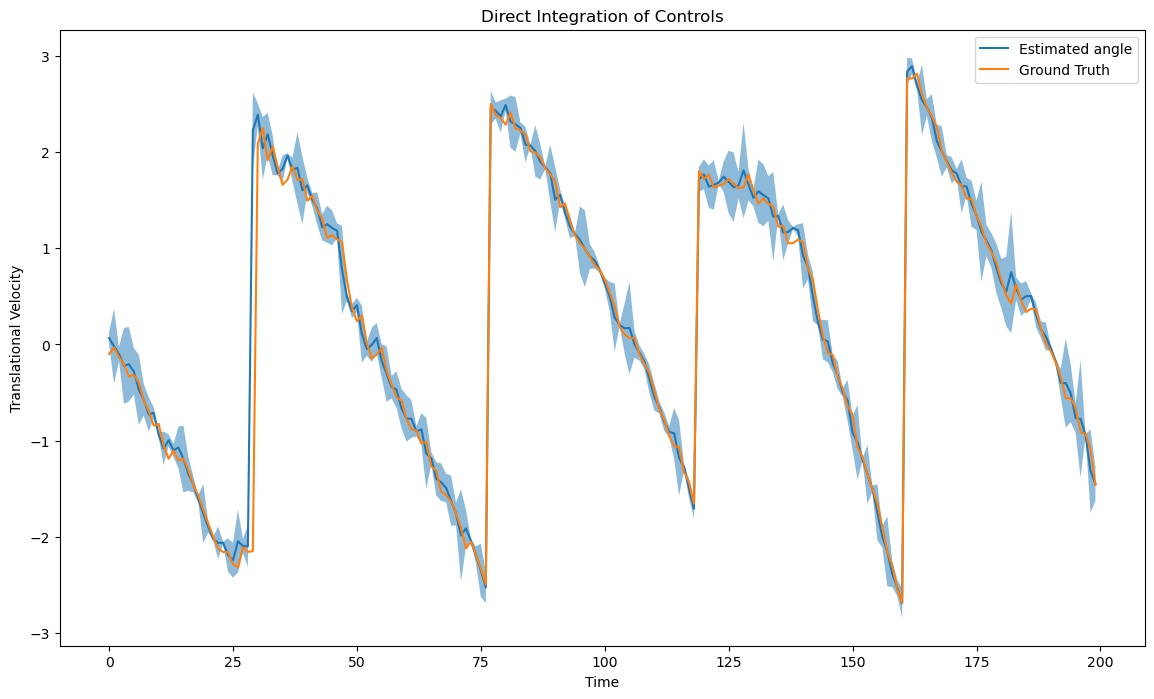

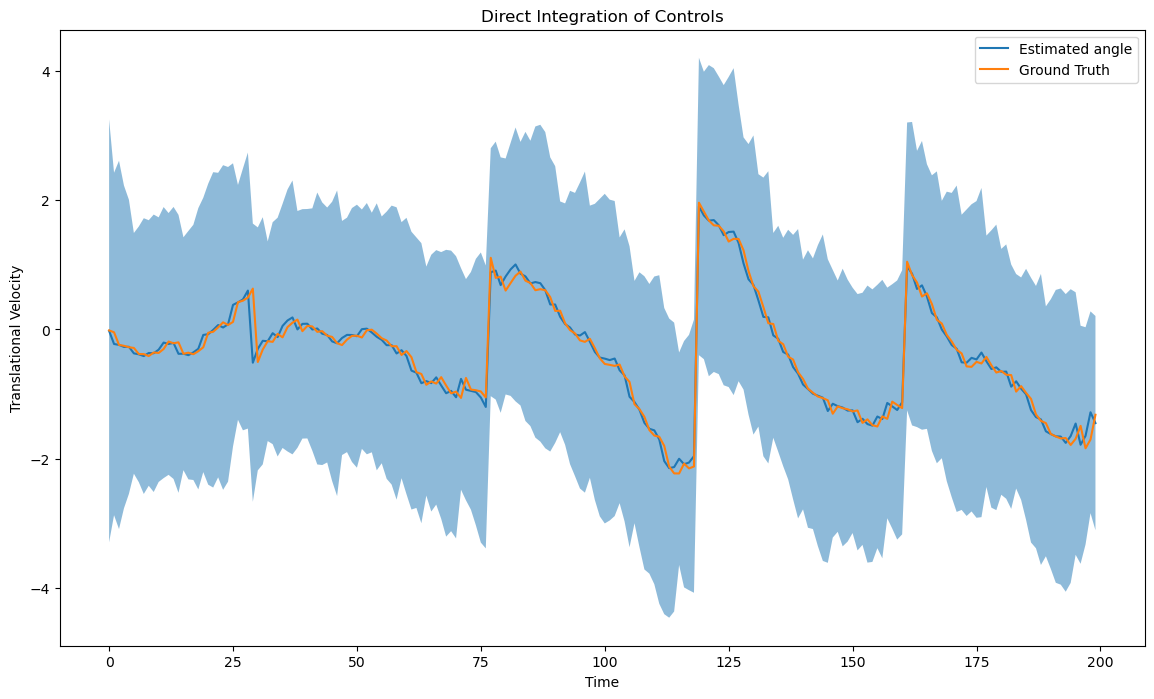

In [30]:
plot_covs(ups, s_ups, 0, gt)
plot_covs(ups, s_ups, 1, gt)
plot_covs(ups, s_ups, 2, gt)